In [1]:
from IPython.core.debugger import set_trace

from os import listdir, mkdir
from os.path import isfile, isdir, join
import copy
import sys
sys.path.append('../financial_utils/')

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

import performance as per

## Model Specification

In [2]:
return_len = 2
return_shift = 1
vix_len = 10
vix_shift = 10
vxst_len = vix_len-1
vxst_shift = vxst_len+1

h1_units = (return_len+vix_len+vxst_len)*4
h2_units = h1_units
#h3_units = 100
step = 1e-6
steps = 10000
batch_size = 16
refresh_rate = 1000
load_model = False

model_dir = 'models'
model_file = 'first'

In [3]:
def leaky_relu64():
    # By default TF uses tf.float32 in alpha. If tf.nn.leaky_relu is used
    # directly in activation of layer.dense, it'll raise an error.
    a=tf.constant(0.2, name='alpha', dtype=tf.float64)
    return lambda features: tf.nn.leaky_relu(features, alpha=a)

In [4]:
tf.reset_default_graph()

model_graph = tf.Graph()
sess = tf.Session(graph=model_graph)
with model_graph.as_default():
    # NET SPECS
    with tf.variable_scope('NET'):
        x = tf.placeholder(name='x', shape=(None, return_len+vix_len+vxst_len), dtype=tf.float64)
        y = tf.placeholder(name='y', shape=(None, 1), dtype=tf.float64)
        H1 = tf.layers.dense(name = 'H1',inputs=x, units = h1_units, activation=tf.nn.tanh)
        H2 = tf.layers.dense(name = 'H2',inputs=H1, units = h2_units, activation=tf.nn.tanh)
        #H3 = tf.layers.dense(name = 'H3',inputs=H2, units = h3_units, activation=tf.nn.tanh)
        output = tf.layers.dense(name = 'output', inputs=H1, units=1, activation=tf.nn.tanh)
    # TRAIN ALGO SPECS
    loss = tf.losses.mean_squared_error(y, output)
    train_step = tf.train.AdamOptimizer(step).minimize(loss)
    saver = tf.train.Saver()
    init = tf.global_variables_initializer()

if not isdir(model_dir):
    mkdir(model_dir)
    
# INITIALIZATION
if load_model:
    saver.restore(sess, model_dir+'/'+model_file)
else:
    sess.run(init)
    saver.save(sess, model_dir+'/'+model_file)
    
writer = tf.summary.FileWriter(model_dir+'/graph', sess.graph)
writer.close()

## Load and Process Dataset 

In [5]:
history_dir = 'history_files'
price_file = 'SPX.csv'
vix_file = 'VIX.csv'
vxst_file = 'VXST.csv'

price_table = pd.read_csv(history_dir+'/'+price_file, parse_dates=[0])
vix_table = pd.read_csv(history_dir+'/'+vix_file, parse_dates=[0])
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
vxst_table = pd.read_csv(history_dir+'/'+vxst_file, parse_dates=[0], date_parser=dateparse)

price_table.drop(['Open', 'Low','High', 'AdjOpen', 'AdjHigh', 'AdjLow','AdjClose'], axis=1, inplace=True)
price_table.columns = ['Date', 'Tick']
returns = per.tick2ret(price_table)
return_table = pd.DataFrame.from_dict({'Date':price_table.Date[1:], 'Return': returns[:,0]})

vix_table.drop(['Open', 'Low','High', 'AdjOpen', 'AdjHigh', 'AdjLow','AdjClose'], axis=1, inplace=True)
vix_table.Close = vix_table.Close/100
vxst_table.drop(['Open', 'Low','High'], axis=1, inplace=True)
vxst_table.Close = vxst_table.Close/100

dataset = pd.merge(pd.merge(return_table, vix_table, how='inner', on=['Date', 'Date']),vxst_table, how='inner', on=['Date','Date'])
dataset.columns = ['Date','Return', 'VIX', 'VXST']
dataset.reset_index(inplace=True)

In [6]:
# STD NORM
dataset_norm = copy.deepcopy(dataset)

return_mean = np.mean(dataset_norm.Return)
return_std = np.std(dataset_norm.Return)
dataset_norm.Return = (dataset_norm.Return - return_mean) / return_std
return_maxnorm = np.max(dataset_norm.Return)
dataset_norm.Return = dataset_norm.Return / return_maxnorm

vix_mean = np.mean(dataset_norm.VIX)
vix_std = np.std(dataset_norm.VIX)
dataset_norm.VIX = (dataset_norm.VIX - vix_mean) / vix_std
vix_maxnorm = np.max(dataset_norm.VIX)
dataset_norm.VIX = dataset_norm.VIX / vix_maxnorm

vxst_mean = np.mean(dataset_norm.VXST)
vxst_std = np.std(dataset_norm.VXST)
dataset_norm.VXST = (dataset_norm.VXST - vxst_mean) / vxst_std
vxst_maxnorm = np.max(dataset_norm.VXST)
dataset_norm.VXST = dataset_norm.VXST / vxst_maxnorm

## Training

In [7]:
def batch_generator(data, batch_size):
    x = np.nan * np.ones((batch_size, return_len+vix_len+vxst_len))
    y = np.nan * np.ones((batch_size, 1))
    while True:
        for j in range(0, batch_size):
            i = np.random.randint(low=np.max([return_len,vix_len,vxst_len]),high=len(data) - np.max([return_shift,vix_shift, vxst_shift]))
            x[j, 0:return_len] = data.Return[i-return_len+return_shift:i+return_shift]
            x[j, return_len:return_len+vix_len] = data.VIX[i-vix_len+vix_shift:i+vix_shift]
            x[j, return_len+vix_len:return_len+vix_len+vxst_len] = data.VXST[i-vxst_len+vxst_shift:i+vxst_shift]
            y[j] = data.VXST[i]
        yield x, y

In [8]:
train_dataset = copy.deepcopy(dataset_norm[0:1200])
train_dataset.reset_index(inplace=True)
vali_dataset = copy.deepcopy(dataset_norm[1200:])
vali_dataset.reset_index(inplace=True)

train_gen = batch_generator(train_dataset, batch_size)
vali_gen = batch_generator(vali_dataset, batch_size)

print('Starting Training...')
for i in range(steps+1):
    x_batch, y_batch = next(train_gen)
    sess.run(train_step, feed_dict={x: x_batch, y: y_batch})
    if not i%refresh_rate:
        print('Iteration: '+str(i))
        x_vali, y_vali = next(vali_gen)
        train_loss = sess.run(loss, feed_dict={x: x_batch, y: y_batch})
        vali_loss = sess.run(loss, feed_dict={x: x_vali, y: y_vali})
        print('Train MSE: {0:2.6f}'.format(train_loss))
        print('Validation MSE: {0:2.6f}'.format(vali_loss))


Starting Training...
Iteration: 0
Train MSE: 0.007928
Validation MSE: 0.017188
Iteration: 1000
Train MSE: 0.126383
Validation MSE: 0.013886
Iteration: 2000
Train MSE: 0.010465
Validation MSE: 0.004245
Iteration: 3000
Train MSE: 0.007516
Validation MSE: 0.004388
Iteration: 4000
Train MSE: 0.001295
Validation MSE: 0.003095
Iteration: 5000
Train MSE: 0.000764
Validation MSE: 0.002316
Iteration: 6000
Train MSE: 0.002022
Validation MSE: 0.005707
Iteration: 7000
Train MSE: 0.001732
Validation MSE: 0.001112
Iteration: 8000
Train MSE: 0.002535
Validation MSE: 0.005747
Iteration: 9000
Train MSE: 0.002204
Validation MSE: 0.000830
Iteration: 10000
Train MSE: 0.001788
Validation MSE: 0.006474


## Manually Test Predictions

2012-01-26 00:00:00


<IPython.core.display.Javascript object>


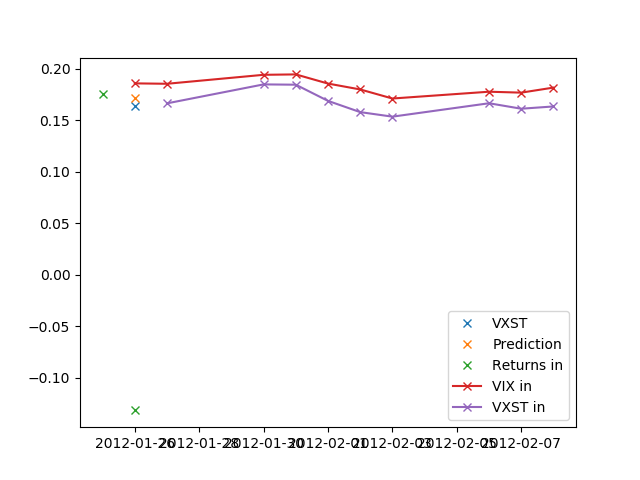

In [21]:
i = np.random.randint(low=np.max([return_len,vix_len,vxst_len]),high=len(dataset) - np.max([return_shift,vix_shift, vxst_shift]))

x_vec = np.nan * np.ones((1, return_len+vix_len+vxst_len))
x_vec[0, 0:return_len] = dataset_norm.Return[i-return_len+return_shift:i+return_shift]
return_sel = dataset_norm[i-return_len+return_shift:i+return_shift]
x_vec[0, return_len:return_len+vix_len] = dataset_norm.VIX[i-vix_len+vix_shift:i+vix_shift]
vix_sel = dataset[i-vix_len+vix_shift:i+vix_shift]
x_vec[0, return_len+vix_len:return_len+vix_len+vxst_len] = dataset_norm.VXST[i-vxst_len+vxst_shift:i+vxst_shift]
vxst_sel = dataset[i-vxst_len+vxst_shift:i+vxst_shift]
vxst_y = dataset.VXST[i]

prediction = sess.run(output, feed_dict={x: x_vec}) * vxst_maxnorm * vxst_std + vxst_mean
#prediction = (sess.run(output, feed_dict={x: x_vec})+ 1) * (vxst_max-vxst_min) / 2  + vxst_min

print(dataset.Date[i])
plt.figure()
plt.plot(dataset.Date[i], vxst_y, marker='x', ls='')
plt.plot(dataset.Date[i], prediction, marker='x', ls='')
plt.plot(return_sel.Date, return_sel.Return, marker='x',ls='')
plt.plot(vix_sel.Date,vix_sel.VIX, marker='x')
plt.plot(vxst_sel.Date,vxst_sel.VXST, marker='x')
plt.legend(['VXST', 'Prediction', 'Returns in', 'VIX in', 'VXST in'])


## VXST Simulation and Error Distribution

<IPython.core.display.Javascript object>


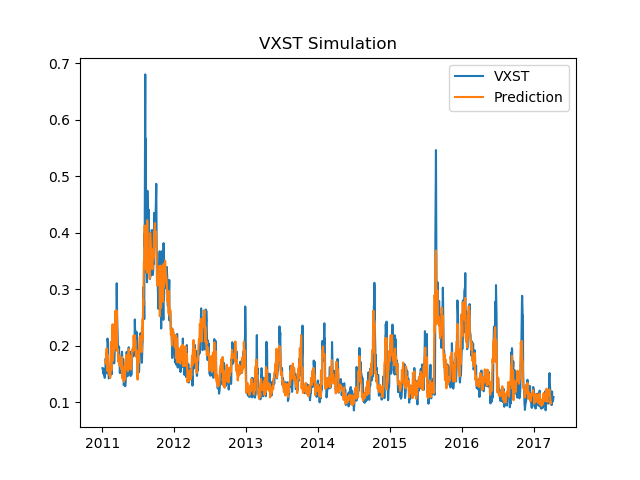

In [19]:
error = np.nan * np.ones((len(dataset),1))
prediction = np.nan * np.ones((len(dataset),1))
prediction_norm = np.nan * np.ones((len(dataset),1))
prediction_date = list()
for i in range(np.max([return_len,vix_len,vxst_len]),len(dataset) - np.max([return_shift,vix_shift, vxst_shift])):
    x_vec = np.nan * np.ones((1, return_len+vix_len+vxst_len))
    x_vec[0, 0:return_len] = dataset_norm.Return[i-return_len+return_shift:i+return_shift]
    x_vec[0, return_len:return_len+vix_len] = dataset_norm.VIX[i-vix_len+vix_shift:i+vix_shift]
    x_vec[0, return_len+vix_len:return_len+vix_len+vxst_len] = dataset_norm.VXST[i-vxst_len+vxst_shift:i+vxst_shift]
    vxst_y = dataset.VXST[i]
    prediction_norm[i,0] = sess.run(output, feed_dict={x: x_vec})
    prediction[i,0] = prediction_norm[i,0] * vxst_maxnorm * vxst_std + vxst_mean
    #prediction[i,0] = (prediction_norm[i,0] + 1) * (vxst_max-vxst_min) / 2 + vxst_min
    prediction_date.append(dataset.Date[i])
    error[i,0] = vxst_y - prediction[i,0]  
error = error[np.where(~np.isnan(error))]
prediction = prediction[np.where(~np.isnan(prediction))]
prediction_norm = prediction_norm[np.where(~np.isnan(prediction_norm))]

plt.figure()
plt.plot(dataset_norm.Date, dataset.VXST)
plt.plot(prediction_date, prediction)
plt.title('VXST Simulation')
plt.legend(['VXST','Prediction'])

<IPython.core.display.Javascript object>


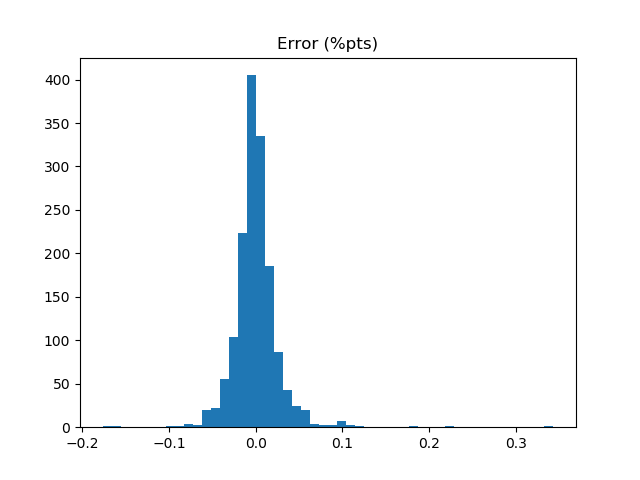

In [20]:
plt.figure()
plt.hist(error,50);
plt.title('Error (%pts)');

## Simulate to 1990

### Full Simulation

In [14]:
retvix_data = pd.merge(pd.merge(return_table, vix_table, how='inner', on=['Date', 'Date']),vxst_table, how='outer', on=['Date','Date'])
retvix_data = pd.merge(retvix_data,vxst_table, how='outer', on=['Date','Date'])
retvix_data = retvix_data.iloc[np.where(~np.isnan(retvix_data.Return))]
retvix_data.reset_index()

retvix_data.columns = ['Date','Return', 'VIX','VXST','VXST_sim']
retvix_data.reset_index(inplace=True)

retvix_data_norm = copy.deepcopy(retvix_data)
retvix_data_norm.Return = (retvix_data_norm.Return - return_mean) / return_std / return_maxnorm
retvix_data_norm.VIX = (retvix_data_norm.VIX - vix_mean) / vix_std / vix_maxnorm
retvix_data_norm.VXST = (retvix_data_norm.VXST - vxst_mean) / vxst_std / vxst_maxnorm


In [17]:
prediction = np.nan * np.ones((len(retvix_data),1))
prediction_date = list()
for i in reversed(range(np.max([return_len,vix_len,vxst_len]),len(retvix_data_norm) - np.max([return_shift,vix_shift, vxst_shift]))):
    x_vec = np.nan * np.ones((1, return_len+vix_len+vxst_len))
    x_vec[0, 0:return_len] = retvix_data_norm.Return[i-return_len+return_shift:i+return_shift]
    x_vec[0, return_len:return_len+vix_len] = retvix_data_norm.VIX[i-vix_len+vix_shift:i+vix_shift]
    x_vec[0, return_len+vix_len:return_len+vix_len+vxst_len] = retvix_data_norm.VXST_sim[i-vxst_len+vxst_shift:i+vxst_shift]
    prediction_norm = sess.run(output, feed_dict={x: x_vec})
    prediction[i,0] = prediction_norm * vxst_maxnorm * vxst_std + vxst_mean
    prediction_date.append(retvix_data_norm.Date[i])
    retvix_data_norm.at[i,'VXST_sim'] =  prediction_norm
    retvix_data.at[i,'VXST_sim'] =  prediction[i,0]


<IPython.core.display.Javascript object>


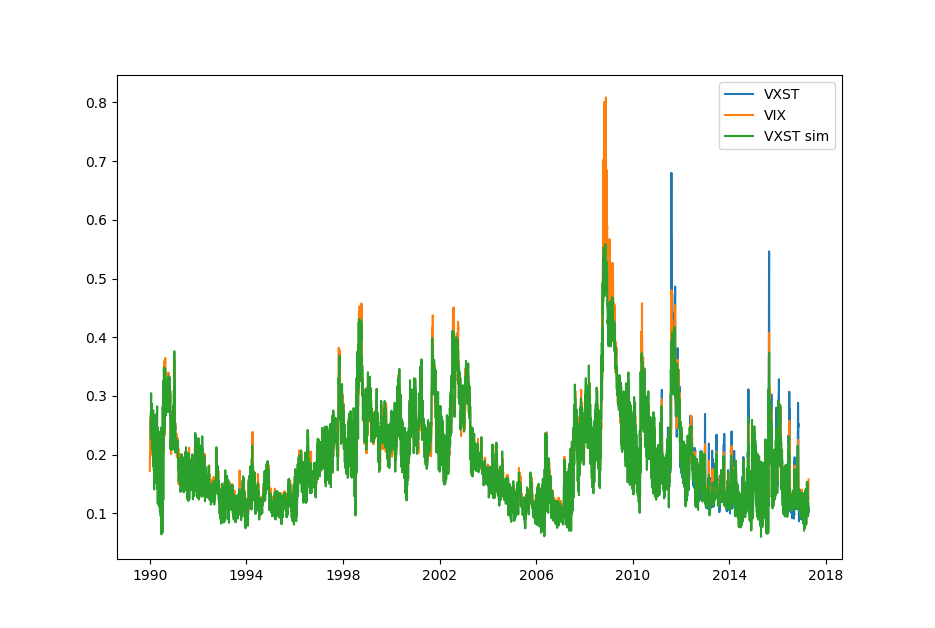

In [18]:
plt.figure()
plt.plot(retvix_data.Date, retvix_data.VXST)
plt.plot(retvix_data.Date, retvix_data.VIX)
plt.plot(retvix_data.Date, retvix_data.VXST_sim)
plt.legend(['VXST','VIX', 'VXST sim'])

### Useful Simulation

## Snippets

In [ ]:
#[-1,1] NORM
dataset_norm = copy.deepcopy(dataset)

vix_min = np.min(dataset_norm.VIX)
vix_max = np.max(dataset_norm.VIX)
dataset_norm.VIX = -1 + (dataset_norm.VIX - vix_min) * 2 / (vix_max-vix_min)

vxst_min = np.min(dataset_norm.VXST)
vxst_max = np.max(dataset_norm.VXST)
dataset_norm.VXST = -1 + (dataset_norm.VXST - vxst_min) * 2 / (vxst_max-vxst_min)